In [1]:
import cv2
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score

In [2]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [3]:
import os
# print(os.getcwd())

In [4]:
import tensorflow as tf
print(tf.__version__)

/Users/alros/computer_vision/computer_vision/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.19.0


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Available GPUs:", gpus)

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # 防止佔滿 GPU 記憶體
    except RuntimeError as e:
        print(e)


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
seed=42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [7]:
def showData(path,title=''):
    image = img.imread(path)
    #避免多通道或單通道無法正常顯示
    if len(image.shape)==2:
        image = image.reshape((image.shape[0],image.shape[1],1))
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        if image.shape[-1]==4:
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
            
    if title !='':
        plt.title(title)
    plt.show()

### 載入資料集

In [8]:
lst_labels = ['covid','normal','pneumonia']
dic = {'image_path':[],'labels':[]}
for lbl in lst_labels:
    folder = f"../dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/{lbl}/"
    for name in os.listdir(folder):
        dic['image_path'].append(folder+name)
        dic['labels'].append(lst_labels.index(lbl))

df_dataest = pd.DataFrame(dic)
df_dataest['labels'] = df_dataest['labels'].astype(int)

### 觀察類別平衡情況

In [9]:
print(len(df_dataest))
df_dataest['labels'].value_counts()

6939


labels
0    2313
1    2313
2    2313
Name: count, dtype: int64

In [10]:
def load_data(img_paths,img_size):
    '''
    1.將圖片轉型縮放成只指定大小
    2.解決將多通道或單通道的圖片統一成RGB三通道
    3.遇到已經過好標準化(0-1)的圖片的話先轉回來(0-255)方便後續SHAP觀察 
    '''
    lst = []
    for p in img_paths:
        image = img.imread(p)
        image = cv2.resize(image, img_size)
        # 處理不同通道的輸入資料
        #
        if len(image.shape)==2:
            image = image.reshape((img_size[0],img_size[1],1))
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        else:
            if image.shape[-1]==4:
                image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

        #方便後續用SHAP觀察使用，發現有標準化資料先轉回來
        if image[0][0][0]<=1:
            image = (image*255.0).astype(np.uint8)
        lst.append(image)
        
    ary = np.array(lst)

    print(ary.shape)
    return ary

def to_y_data(data,num_classes):
    count = len(data)
    ary = np.zeros((len(data), num_classes),dtype=int)

    for i in range(count):
        ary[i][data[i]]=1
    return ary

In [11]:
#設定訓練資料的尺寸和model輸入的大小 
image_w_h = 256

In [12]:
data = df_dataest.sample(1000,random_state=42)

In [13]:
data['labels'].value_counts()

labels
0    346
1    340
2    314
Name: count, dtype: int64

In [14]:
X_train, X_val, y_train, y_val = train_test_split(data['image_path'], data['labels'], test_size=0.2, random_state=42)
X_train_img = load_data(X_train,(image_w_h,image_w_h))
X_val_img = load_data(X_val,(image_w_h,image_w_h))

#標準化：降低模型加速收斂
X_train = X_train_img/255.0
X_val = (X_val_img/255.0)


#轉換成類別標籤
y_train = to_y_data(y_train.to_list(),3)
y_val = to_y_data(y_val.to_list(),3)


(800, 256, 256, 3)
(200, 256, 256, 3)


In [15]:
print('X_train',X_train.shape,'y_train',y_train.shape)
print('X_val  ',X_val.shape,' y_val  ',y_val.shape)

X_train (800, 256, 256, 3) y_train (800, 3)
X_val   (200, 256, 256, 3)  y_val   (200, 3)


### 模型架構
<h>1.主要是學習量化的語法，所以把Vgg16改成參數凍結，加速模型完成訓練</h>

In [16]:
vgg = tf.keras.applications.VGG16(include_top = False,input_shape = (image_w_h,image_w_h,3))
vgg.trainable=False
x = tf.keras.layers.Flatten()(vgg.output)
x = tf.keras.layers.Dense(50,activation='relu')(x)
x = tf.keras.layers.Dense(3, activation = 'softmax')(x)
model = tf.keras.Model(vgg.input, x)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy','auc','recall','precision'])
model.summary()

2025-03-12 23:09:09.698017: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-12 23:09:09.698039: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-12 23:09:09.698044: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1741792149.698054  382774 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1741792149.698071  382774 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │     1,638,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,353,291 (62.38 MB)

 Trainable params: 1,638,603 (6.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',
                                            restore_best_weights=True,
                                            min_delta=0.025,
                                            start_from_epoch=3,
                                            patience=3)

In [18]:
history = model.fit(X_train, y_train,batch_size=50,validation_data=(X_val,y_val), epochs=20,callbacks=[callback])

Epoch 1/20


2025-03-12 23:09:10.812038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4090 - auc: 0.5650 - loss: 1.2141 - precision: 0.4234 - recall: 0.2801 - val_accuracy: 0.5150 - val_auc: 0.7312 - val_loss: 0.9945 - val_precision: 0.8750 - val_recall: 0.0700
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5392 - auc: 0.7472 - loss: 0.9703 - precision: 0.7543 - recall: 0.0883 - val_accuracy: 0.7150 - val_auc: 0.8621 - val_loss: 0.8765 - val_precision: 0.8800 - val_recall: 0.2200
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7241 - auc: 0.8820 - loss: 0.8460 - precision: 0.8871 - recall: 0.2678 - val_accuracy: 0.7800 - val_auc: 0.9103 - val_loss: 0.7694 - val_precision: 0.9186 - val_recall: 0.3950
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7890 - auc: 0.9192 - loss: 0.7518 - precision: 0.8824 - recall: 0.4181 - val_accuracy: 0.8150 - val_auc: 0.9331 - val_loss: 0.6932 - val_precision: 0.9016 - val_recall: 0.5500
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step -

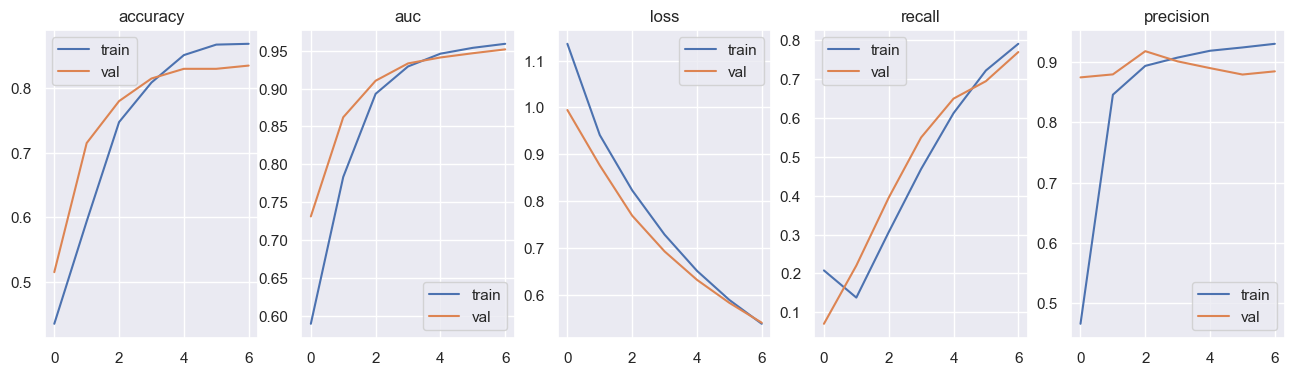

In [ ]:
df_hostory = pd.DataFrame(history.history)
df_hostory['epochs'] = df_hostory.index
fig, axes = plt.subplots(1,5,figsize=(16,4))
lst = ['accuracy','auc','loss','recall','precision']
for i in range(len(lst)):
    axes[i].set_title(lst[i])
    sns.lineplot(df_hostory,x='epochs',y=lst[i],label='train',ax=axes[i])
    sns.lineplot(df_hostory,x='epochs',y='val_'+lst[i],label='val',ax=axes[i])
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
plt.show()

### 搭建要量化的模型架構
<h>1.要量化的模型需使用不同的模組的keras建立架構</h>

<h>2.嘗試過程有發現Sequential model不能直接進行量化，所以，才改成functional建立架構，這也是為什麼上面會用functional的方式建構</h>

<h>3.functional另一個好處是相同結構的模型可以輕鬆的傳遞訓練好的的權重</h>

<h>4.延續3下方的模型也可以訓練，這邊故意嘗試不同模組看權重是否能共用</h>

In [ ]:
from tensorflow_model_optimization.python.core.keras.compat import keras

In [83]:
vgg = keras.applications.VGG16(include_top = False,input_shape = (image_w_h,image_w_h,3))
vgg.trainable=False
x = keras.layers.Flatten()(vgg.output)
x = keras.layers.Dense(50,activation='relu')(x)
x = keras.layers.Dense(3, activation = 'softmax')(x)
model_for_q = keras.Model(vgg.input, x)
model_for_q.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy','auc','recall','precision'])
model_for_q.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

### 塞入前訓練好的權重

In [84]:
for i in range(len(model.layers)):
    model_for_q.layers[i].set_weights(model.layers[i].get_weights())

### 進行模擬的量化感知訓練(QAT)

<h>1.這邊有個重點，目前tensorflow的QAT不能凍結權重</h>

<h>2.同時也可以觀察一下，如果沒凍結的話模型量化前後的差異</h>

In [56]:
import tensorflow_model_optimization as tfmot

In [86]:
# q_aware stands for for quantization aware.
q_aware_model = tfmot.quantization.keras.quantize_model(model_for_q)

In [100]:
# `quantize_model` requires a recompile.
q_aware_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.legacy.Adam(learning_rate=0.00001),
              metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.AUC(),keras.metrics.Recall(),keras.metrics.Precision()])

q_aware_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 quantize_layer_6 (Quantize  (None, 256, 256, 3)       3         
 Layer)                                                          
                                                                 
 quant_block1_conv1 (Quanti  (None, 256, 256, 64)      1923      
 zeWrapperV2)                                                    
                                                                 
 quant_block1_conv2 (Quanti  (None, 256, 256, 64)      37059     
 zeWrapperV2)                                                    
                                                                 
 quant_block1_pool (Quantiz  (None, 128, 128, 64)      1         
 eWrapperV2)                                               

In [102]:
q_aware_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 quantize_layer_6 (Quantize  (None, 256, 256, 3)       3         
 Layer)                                                          
                                                                 
 quant_block1_conv1 (Quanti  (None, 256, 256, 64)      1923      
 zeWrapperV2)                                                    
                                                                 
 quant_block1_conv2 (Quanti  (None, 256, 256, 64)      37059     
 zeWrapperV2)                                                    
                                                                 
 quant_block1_pool (Quantiz  (None, 128, 128, 64)      1         
 eWrapperV2)                                               

In [103]:
print('X_train',X_train.shape,'y_train',y_train.shape)
print('X_val  ',X_val.shape,' y_val  ',y_val.shape)

X_train (800, 256, 256, 3) y_train (800, 3)
X_val   (200, 256, 256, 3)  y_val   (200, 3)


In [105]:
q_aware_history = q_aware_model.fit(x=X_train, y=y_train,batch_size=50,validation_data=(X_val,y_val), epochs=3)

Epoch 1/3
16/16 [==============================] - 163s 10s/step - loss: 0.2421 - categorical_accuracy: 0.9275 - auc_3: 0.9855 - recall_3: 0.9100 - precision_3: 0.9345 - val_loss: 0.2750 - val_categorical_accuracy: 0.8800 - val_auc_3: 0.9796 - val_recall_3: 0.8700 - val_precision_3: 0.8923
Epoch 2/3
16/16 [==============================] - 160s 10s/step - loss: 0.1792 - categorical_accuracy: 0.9450 - auc_3: 0.9919 - recall_3: 0.9413 - precision_3: 0.9496 - val_loss: 0.2465 - val_categorical_accuracy: 0.9050 - val_auc_3: 0.9831 - val_recall_3: 0.8800 - val_precision_3: 0.9119
Epoch 3/3
16/16 [==============================] - 158s 10s/step - loss: 0.1398 - categorical_accuracy: 0.9588 - auc_3: 0.9949 - recall_3: 0.9550 - precision_3: 0.9610 - val_loss: 0.1929 - val_categorical_accuracy: 0.9450 - val_auc_3: 0.9866 - val_recall_3: 0.9450 - val_precision_3: 0.9497


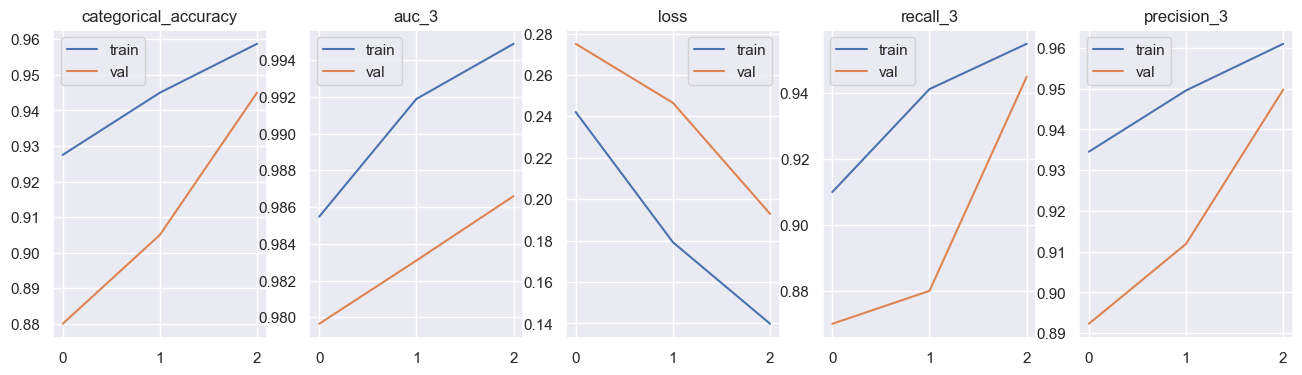

In [108]:
df_q_aware_hostory = pd.DataFrame(q_aware_history.history)
df_q_aware_hostory['epochs'] = df_q_aware_hostory.index
fig, axes = plt.subplots(1,5,figsize=(16,4))
lst = ['categorical_accuracy','auc_3','loss','recall_3','precision_3']
for i in range(len(lst)):
    axes[i].set_title(lst[i])
    sns.lineplot(df_q_aware_hostory,x='epochs',y=lst[i],label='train',ax=axes[i])
    sns.lineplot(df_q_aware_hostory,x='epochs',y='val_'+lst[i],label='val',ax=axes[i])
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
plt.show()

In [110]:
data_test = df_dataest.loc[df_dataest.index.isin(data.index)==False]
data_test = data_test.sample(200,random_state=42)
data_test['labels'].value_counts()

labels
1    71
0    69
2    60
Name: count, dtype: int64

In [167]:
X_test_img = load_data(data_test['image_path'],(image_w_h,image_w_h))
X_test = X_test_img/255.0
y_test = to_y_data(data_test['labels'].to_list(),3)

print('X_test',X_test.shape,'y_test',y_test.shape)

(200, 256, 256, 3)
X_test (200, 256, 256, 3) y_test (200, 3)


In [116]:
true_labels = np.argmax(y_test,axis=1)

In [188]:
dic_result = {"model's type":['ori model','QAT model','Quantization'],'accuracy':[],'recall':[],'precision':[],'auc':[]}

### 比較一下，最早凍結參數的模型、模擬QAT後的模型、量化後的模型差異

### 最早凍結參數的模型

In [ ]:
preds = model_for_q.predict(X_test,verbose=0)
pred_labels = np.argmax(preds,axis=1)

dic_result['accuracy'].append(accuracy_score(true_labels,np.argmax(preds,axis=1)))
dic_result['recall'].append(recall_score(true_labels,pred_labels,average='micro'))
dic_result['precision'].append(precision_score(true_labels,pred_labels,average='micro'))
dic_result['auc'].append(roc_auc_score(y_test,preds,average='micro',multi_class='ovr'))


### 模擬QAT後的模型

In [ ]:
preds = q_aware_model.predict(X_test,verbose=0)
pred_labels = np.argmax(preds,axis=1)

dic_result['accuracy'].append(accuracy_score(true_labels,np.argmax(preds,axis=1)))
dic_result['recall'].append(recall_score(true_labels,pred_labels,average='micro'))
dic_result['precision'].append(precision_score(true_labels,pred_labels,average='micro'))
dic_result['auc'].append(roc_auc_score(y_test,preds,average='micro',multi_class='ovr'))


### 量化後的模型

<h>1.將模型透過TFLite進行量化</h>

<h>2.這邊沒有作Layerwise、Channelwise及量化精度的配置交由套件他自行最佳化</h>

<h>3.從下方秀出的配置結果可以看到，他是沒有全部都改成INT的</h>

<h>4.還邊還有個重點，如果是用MAC，目前GPU沒有針對量化優化，所以會用CPU去跑推論，主要的優勢就變成是節省空間</h>

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
# 訪問模型的權重
interpreter.allocate_tensors()
tensor_details = interpreter.get_tensor_details()

# 顯示權重的數據類型（如 INT8）
for tensor in tensor_details:
    tensor_name = tensor['name']
    tensor_dtype = tensor['dtype']
    print(f"Layer: {tensor_name}, dtype: {tensor_dtype}")

INFO:tensorflow:Assets written to: /var/folders/cq/b59py2rn7dz4b4pcbt4fzk8m0000gn/T/tmpa6zbb1rt/assets


INFO:tensorflow:Assets written to: /var/folders/cq/b59py2rn7dz4b4pcbt4fzk8m0000gn/T/tmpa6zbb1rt/assets


Layer: serving_default_input_2:0, dtype: <class 'numpy.float32'>
Layer: arith.constant, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst1, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst2, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst3, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst4, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst5, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst6, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst7, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst8, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst9, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst10, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst11, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst12, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst13, dtype: <class 'numpy.int32'>
Layer: tfl.pseudo_qconst14, dtype: <class 'numpy.int32'>
Layer: model_1/quantize_layer_6/AllValu

/Users/alros/computer_vision/computer_vision/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1741799258.069757  382774 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1741799258.069773  382774 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-13 01:07:38.069950: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/cq/b59py2rn7dz4b4pcbt4fzk8m0000gn/T/tmpa6zbb1rt
2025-03-13 01:07:38.075670: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-13 01:07:38.075687: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/cq/b59py2rn7dz4b4pcbt4fzk8m0000gn/T/tmpa6zbb1rt
2025-03-13 01:07:38.112201: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-13 01:07:38.346493:

In [ ]:
# A helper function to evaluate the LiteRT model using "test" dataset.
def evaluate_model(interpreter,X_test):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in X_test.copy():
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    probability = output()[0].copy()
    prediction_digits.append(probability)

  return prediction_digits

In [ ]:
preds = evaluate_model(interpreter,X_test)

pred_labels = np.argmax(preds,axis=1)
dic_result['accuracy'].append(accuracy_score(true_labels,np.argmax(preds,axis=1)))
dic_result['recall'].append(recall_score(true_labels,pred_labels,average='micro'))
dic_result['precision'].append(precision_score(true_labels,pred_labels,average='micro'))
dic_result['auc'].append(roc_auc_score(y_test,preds,average='micro',multi_class='ovr'))

### 模型表現比較

<h>1.從下方的指標數值可以發現因為無法凍結權重，結果在QAT時反而可以分數都還能上升，甚至真實量化後，還可以贏過位量化的模型</h>

<h>2.量化後的模型因為是用CPU(GPU不支援量化後的計算)跑的緣故，推論速度會比較慢</h>


In [ ]:
pd.DataFrame(dic_result)

,model's type,accuracy,recall,precision,auc
0,ori model,0.79,0.79,0.79,0.930300
1,QAT model,0.92,0.92,0.92,0.982806
2,Quantization,0.87,0.87,0.87,0.972994


In [ ]:
import tempfile

In [ ]:
# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model_for_q)
float_tflite_model = float_converter.convert()

qat_float_converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
qat_float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')
_, qat_float_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(tflite_quant_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

with open(qat_float_file, 'wb') as f:
  f.write(qat_float_tflite_model)

print("Float model in Mb:", os.path.getsize(float_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))
print("QAT model in Mb:", os.path.getsize(qat_float_file) / float(2**20))

INFO:tensorflow:Assets written to: /var/folders/cq/b59py2rn7dz4b4pcbt4fzk8m0000gn/T/tmp32hsppvw/assets


INFO:tensorflow:Assets written to: /var/folders/cq/b59py2rn7dz4b4pcbt4fzk8m0000gn/T/tmp32hsppvw/assets
W0000 00:00:1741799782.574552  382774 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1741799782.574561  382774 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-13 01:16:22.574691: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/cq/b59py2rn7dz4b4pcbt4fzk8m0000gn/T/tmp32hsppvw
2025-03-13 01:16:22.576210: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-13 01:16:22.576215: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/cq/b59py2rn7dz4b4pcbt4fzk8m0000gn/T/tmp32hsppvw
2025-03-13 01:16:22.586364: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-13 01:16:22.648606: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/cq/b59py2rn

INFO:tensorflow:Assets written to: /var/folders/cq/b59py2rn7dz4b4pcbt4fzk8m0000gn/T/tmpzj4iqkir/assets


INFO:tensorflow:Assets written to: /var/folders/cq/b59py2rn7dz4b4pcbt4fzk8m0000gn/T/tmpzj4iqkir/assets
W0000 00:00:1741799784.125588  382774 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1741799784.125598  382774 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-13 01:16:24.125735: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/cq/b59py2rn7dz4b4pcbt4fzk8m0000gn/T/tmpzj4iqkir
2025-03-13 01:16:24.127240: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-13 01:16:24.127245: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/cq/b59py2rn7dz4b4pcbt4fzk8m0000gn/T/tmpzj4iqkir
2025-03-13 01:16:24.136487: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-13 01:16:24.200407: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/cq/b59py2rn

Float model in Mb: 62.39079284667969
Quantized model in Mb: 15.7159423828125
QAT model in Mb: 62.39079284667969


<h>從上方可以看出，在Tensorflow使用它標準的量化語法對MAC來說的優勢只有模型檔案變小</h>
